In [ ]:
import pandas as pd
import numpy as np
from glob import glob
import requests
import seaborn as sns
import json
from sklearn.preprocessing import MinMaxScaler

#### Data preprocessing

In [ ]:
# site id
sites = {
  'Merriwa': 329,
  'Lidcombe': 1141,
}

path_prefix = 'drive/MyDrive'

class AQMS_API:
  def __init__(self):
    self.url_prefix = 'https://data.airquality.nsw.gov.au/api/Data/'
    self.headers = {
      'content-type': 'application/json',
      'accept': 'application/json',
    }
        
    self.site_url = 'get_SiteDetails'
    self.parameter_url = 'get_ParameterDetails'
    self.observation_url = 'get_Observations'
        
  def get_data(self, url_suffix, http_method=requests.get, data=None):
    query = self.url_prefix + url_suffix
    response = http_method(url=query, headers=self.headers, json=data)
    return response.json()
    
  def get_sites(self):
    return self.get_data(self.site_url)
  
  def get_parameters(self):
    return self.get_data(self.parameter_url)
  
  def get_observations(self, data=None):
    return self.get_data(self.observation_url, requests.post, data)

# historical observation query builder
def obs_builder(parameter=None, sites=None, start=None, end=None, category=None, sub_category=None, freq=None):
  '''
  start & end : '%Y-%m-%d' format date string
  '''
  def list_parser(s):
    if s is None or isinstance(s, list):
      return s
    else:
      return [s]

  return {
    'Parameters': list_parser(parameter),
    'Sites': list_parser(sites),
    'StartDate': start,
    'EndDate': end,
    'Categories': list_parser(category),
    'SubCategories': list_parser(sub_category),
    'Frequency': list_parser(freq),
  }

In [ ]:
def df_column_switch(df, column1, column2):
  i = list(df.columns)
  a, b = i.index(column1), i.index(column2)
  i[b], i[a] = i[a], i[b]
  df = df[i]
  return df


def parse_CL(site, path=f'{path_prefix}/Ceilometer/'):
  df = pd.concat([pd.read_csv(file) for file in glob(f'{path}*{site}.csv')])

  # replace -999 to NaN
  df = df.replace(-999, np.nan)

  # parse date string
  df['# Time'] = pd.to_datetime(df['# Time'], format='%d/%m/%Y %H:%M:%S')
  
  # interpolate by time
  df = df.set_index('# Time').interpolate(method='time').reset_index()

  # aggregate by hourly average
  df = df.groupby([
    df['# Time'].dt.strftime('%Y-%m-%d').rename('Date'),
    df['# Time'].dt.hour.rename('Hour'),
  ]).mean().reset_index()
  
  df = df.rename(columns={'bl_height': 'CL_BLH'})

  return df_column_switch(df, 'CL_BLH', 'cloud_dat')


def parse_CTM(site, path=f'{path_prefix}/CTM_ModelOutput/', time_offset=10):
  # Careful! The seperator is not ',' but ', ' (space)
  df = pd.concat([pd.read_csv(file, sep=r'\s*,\s*', engine='python') for file in glob(f'{path}*{site}.csv')])

  # parse date string
  from datetime import timedelta
  df['Time'] = pd.to_datetime(df[['date', 'time']].astype(str).apply('-'.join, 1), format='%Y%m%d-%H') + timedelta(hours=time_offset)

  # interpolate by time
  df = df.set_index('Time').interpolate(method='time').reset_index()

  # aggregate by hourly average
  df = df.groupby([
      df['Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
      df['Time'].dt.hour.rename('Hour')
  ]).mean().reset_index()
  df = df.rename(columns={'mixing_height': 'CTM_BLH'})

  return df[['Date', 'Hour', 'CTM_BLH']]


def parse_WRF(site, path=f'{path_prefix}/WRF_PBLH/', time_offset=10):
  sites = {
    'Merriwa': 329,
    'Lidcombe': 2141,
  }

  df = pd.concat([pd.read_csv(file, sep='\s+', names=['datetime', 'WRF_BLH']) for file in glob(f'{path}*{sites[site]}_*.txt')])

  # parse date string
  from datetime import timedelta
  df['Time'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d_%H:%M:%S') + timedelta(hours=time_offset)

  df = df.set_index('Time')
  df = df[~df.index.duplicated(keep = 'last')]
  df = df.reset_index()

  # aggregate by hourly average
  df = df.groupby([
      df['Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
      df['Time'].dt.hour.rename('Hour')
  ]).mean().reset_index()

  return df


def bl_external(site):
  api = AQMS_API()
  params_df = pd.DataFrame.from_records(api.get_parameters())
  params = params_df.loc[
      (params_df['Category'] == 'Averages') & 
      (params_df['SubCategory'] == 'Hourly') & 
      (params_df['Frequency'] == 'Hourly average')
  ]

  param_list = params['ParameterCode'].tolist()
  param_list.remove('SOLAR')

  query = obs_builder(
    param_list, 
    sites[site], 
    '2021-02-12',
    '2021-02-20',
    'Averages', 
    'Hourly', 
    'Hourly average'
  )

  obs = pd.DataFrame.from_records(api.get_observations(query))
  obs['Hour'] = obs['Hour'] - 1
  obs['Parameter'] = pd.json_normalize(obs['Parameter'])['ParameterDescription']
  obs = pd.pivot(obs, index=['Date', 'Hour'], columns='Parameter', values='Value').reset_index()

  # parse date string
  from datetime import timedelta
  obs['Time'] = pd.to_datetime(obs[['Date', 'Hour']].astype(str).apply('-'.join, 1), format='%Y-%m-%d-%H')

  # interpolate by time
  obs = obs.set_index('Time').interpolate(method='time').reset_index()

  return obs.drop(columns=['Time'])


def get_site_data(site):
  CL_df = parse_CL(site).set_index(['Date', 'Hour'])
  CTM_df = parse_CTM(site).set_index(['Date', 'Hour'])
  WRF_df = parse_WRF(site).set_index(['Date', 'Hour'])
  external_df = bl_external(site).set_index(['Date', 'Hour'])
  df = external_df.join([CL_df, CTM_df, WRF_df], how='inner').reset_index()
  return df_column_switch(df, 'CL_BLH', 'WRF_BLH')


def get_data():
  try:
    return {site: pd.read_csv(f'{path_prefix}/{site}_cleaned.csv') for site in sites.keys()}
  except FileNotFoundError:
    data = {}
    for site in sites.keys():
      data[site] = get_site_data(site)
      data[site].to_csv(f'{path_prefix}/{site}_cleaned.csv', index=False)
    return data

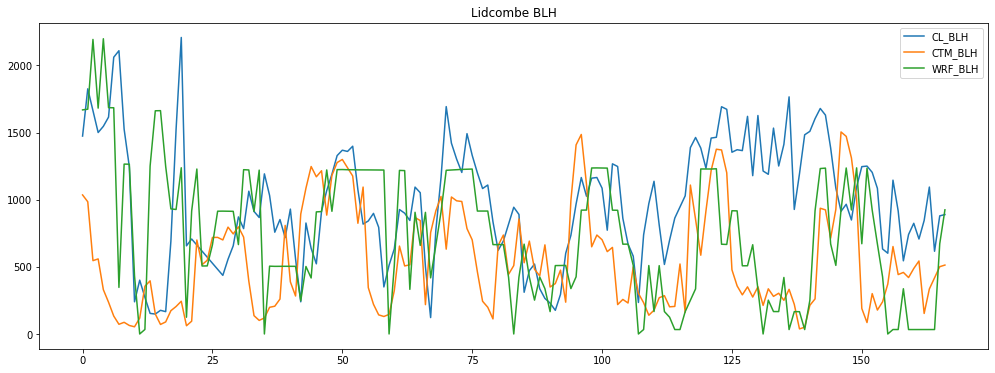

In [ ]:
data = get_data()

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (17, 6)
data['Lidcombe'].plot(y=['CL_BLH', 'CTM_BLH', 'WRF_BLH'], title='Lidcombe BLH')

# Statistical measurements

In [ ]:
'''
Function: Calculates and prints out the varoius metrics
'''
from sklearn.metrics import mean_absolute_error, mean_squared_error

def index_agreement(s, o):
    """
    index of agreement

    Willmott (1981, 1982) 
    input:
        s: simulated
        o: observed
    output:
        ia: index of agreement
    """
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    return ia


def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    n = training_series.shape[0]
    d = np.abs(np.diff( training_series)).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d


from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def satistical_comps(y_true, y_pred, train_series, title):    
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mae = mean_absolute_error(y_true, y_pred)
  mbe = np.mean(y_pred - y_true)
  ioa = index_agreement(y_pred, y_true)
  dtw_dist, path = fastdtw(y_true, y_pred, dist=euclidean)
  mase = MASE(train_series, y_pred, y_true)
  
  print('%s\nIndex of agreement:%.5f\nRoot mean squared error:%.5f\nMean absoluate error:%.5f\nMean bias error:%.5f\nDTW distance:%.2f\nMean Absolute scaled error:%.5f' % (title, ioa, rmse, mae, mbe, dtw_dist, mase))


In [ ]:
def pred_plots(df, y_pred, model_name, title, scaler, train_series):
  df = df.iloc[-24:,-3:].copy()
  df[model_name] = y_pred
  df[df.columns] = scaler.inverse_transform(df)

  title = model_name + title

  resid_plot_title = 'Residual plot ' + title
  pred_plot_title = 'Predict vs. Real ' + title
  
  sns.set_theme(style="whitegrid")

  # Plot the residuals after fitting
  ax1 = plt.subplot(121)
  sns.residplot(x='CL_BLH', y=model_name, data=df, lowess=True, color="g", ax=ax1).set(title = resid_plot_title)
  ax2 = plt.subplot(122)
  df.plot(y=['CL_BLH', 'CTM_BLH', 'WRF_BLH', model_name], title=pred_plot_title, ax=ax2)
  plt.show()
  
  satistical_comps(df['CL_BLH'], df[model_name], scaler.inverse_transform(train_series).squeeze(), title)

  return df

# Predict next 24 hours


In [ ]:
from keras.models import Sequential
from keras.layers import *

def multi_step_split(df, feature_list, n_steps_in, n_steps_out):
  input_sequence = df[feature_list].values.astype('float32')
  output_sequence = df[['CL_BLH']].values.astype('float32')
  X, y = list(), list()
  for i in range(len(df) - n_steps_in - n_steps_out + 1):
    end_ix = i + n_steps_in
    seq_x, seq_y = input_sequence[i:end_ix], output_sequence[end_ix:end_ix+n_steps_out,-1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)


def modeller(site, feature_list, model_func, epochs=200, **kwargs):
  # scale to (0,1)
  X_scaler, y_scaler = MinMaxScaler(), MinMaxScaler()
  df = data[site].copy()
  df.iloc[:,2:-3] = X_scaler.fit_transform(df.iloc[:,2:-3])

  y_scaler.fit(df[['CL_BLH']])
  df.iloc[:,-3:] = y_scaler.transform(df.iloc[:,-3:])

  # split to lag
  n_steps_in, n_steps_out = 48, 24
  X, y = multi_step_split(df, feature_list, n_steps_in, n_steps_out)

  model = model_func(n_steps_in, n_steps_out, len(feature_list))
  model.compile(optimizer='adam', loss='mse')
  # fit model
  model.fit(X[:-1], y[:-1], epochs=epochs, verbose=0, **kwargs)
  # predict
  y_pred = model.predict(X[-1:]).squeeze()
  # plot
  y_df = pred_plots(df, y_pred, model_func.__name__, f' @ {site} next 24 hour', y_scaler, df[['CL_BLH']].iloc[:-24])

  overall_df[site][model_func.__name__] = y_df

#### Vanilla LSTM

In [ ]:
def vanilla_LSTM(n_steps_in, n_steps_out, n_features):
  model = Sequential()
  model.add(LSTM(100, input_shape=(n_steps_in, n_features)))
  model.add(Dense(n_steps_out))
  return model

#### Vector Output Model

In [ ]:
def vector_model(n_steps_in, n_steps_out, n_features):
  model = Sequential()
  model.add(LSTM(100, return_sequences=True, input_shape=(n_steps_in, n_features)))
  model.add(LSTM(100))
  model.add(Dense(n_steps_out))
  return model

#### Encoder-Decoder Model

In [ ]:
def encoder_decoder(n_steps_in, n_steps_out, n_features):
  model = Sequential()
  model.add(LSTM(100, input_shape=(n_steps_in, n_features)))
  model.add(RepeatVector(n_steps_out))
  model.add(LSTM(100, return_sequences=True))
  model.add(TimeDistributed(Dense(1)))
  return model

# Overall plot

In [ ]:
from functools import reduce
from collections import defaultdict

overall_df = defaultdict(dict)

def overall_plot(site, feature_list):
  models = [vanilla_LSTM, vector_model, encoder_decoder]
  for model in models:
    modeller(site, feature_list, model, epochs=200)
    print('\n')
  site_overall_df = reduce(lambda x, y: pd.merge(x, y), overall_df[site].values())
  site_overall_df.plot(title=f'Actual vs Predicted BLH plots in {site} considering various models')

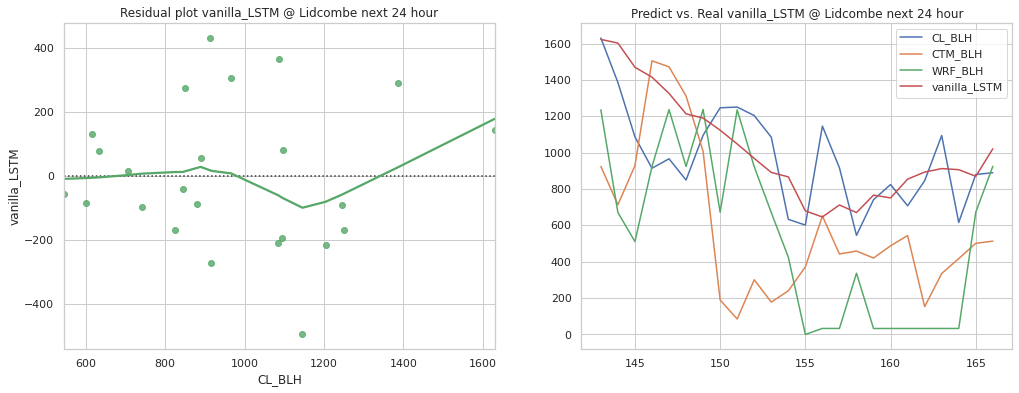

vanilla_LSTM @ Lidcombe next 24 hour
Index of agreement:0.78551
Root mean squared error:241.25436
Mean absoluate error:197.08094
Mean bias error:52.68161
DTW distance:3469.68
Mean Absolute scaled error:0.90019




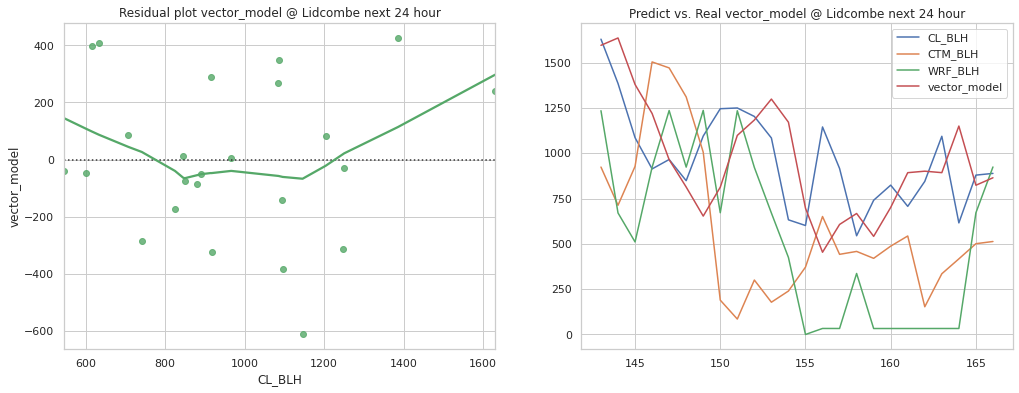

vector_model @ Lidcombe next 24 hour
Index of agreement:0.72415
Root mean squared error:289.36773
Mean absoluate error:221.72346
Mean bias error:-5.00731
DTW distance:2304.22
Mean Absolute scaled error:1.01275




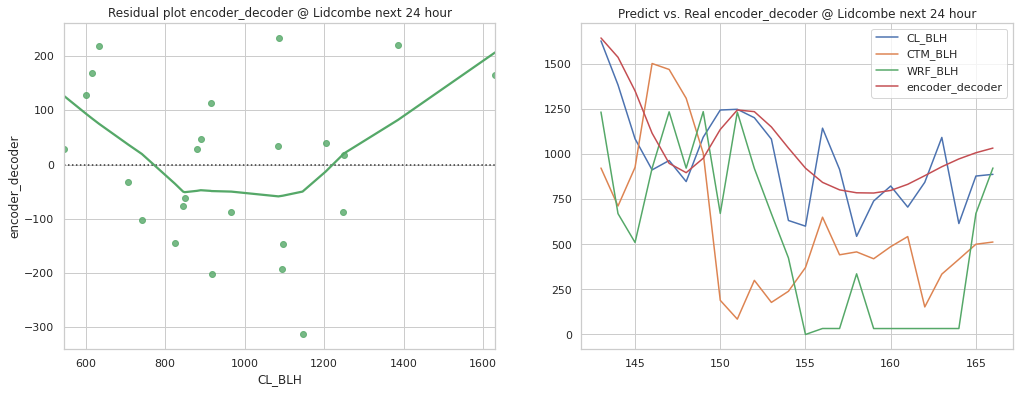

encoder_decoder @ Lidcombe next 24 hour
Index of agreement:0.85282
Root mean squared error:183.79640
Mean absoluate error:143.52217
Mean bias error:73.01574
DTW distance:2709.30
Mean Absolute scaled error:0.65556




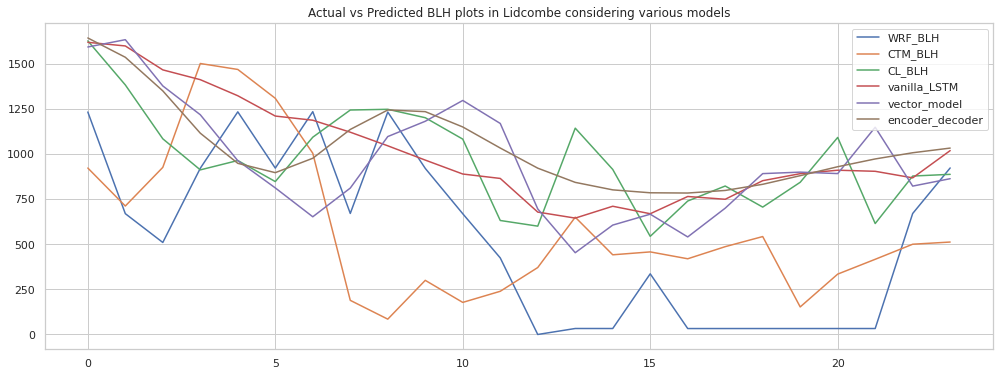

In [ ]:
feature_list = [
  'Humidity',
  'Temperature',
  'CL_BLH',
]

overall_plot('Lidcombe', feature_list)

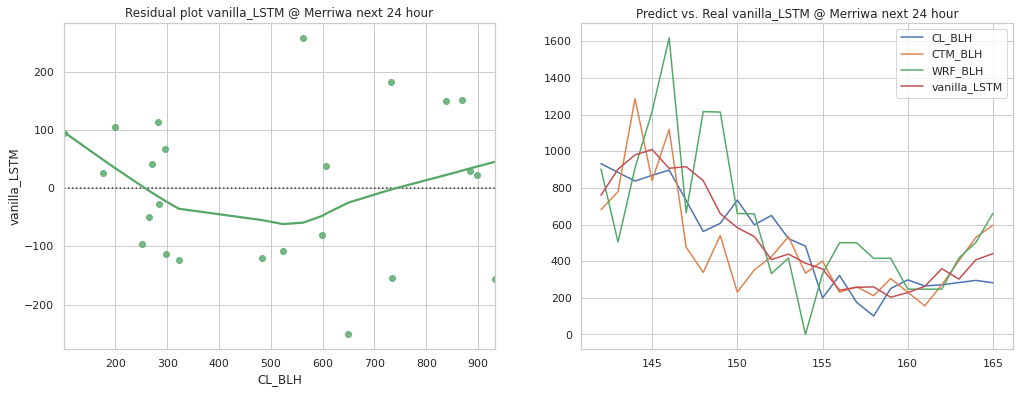

vanilla_LSTM @ Merriwa next 24 hour
Index of agreement:0.93684
Root mean squared error:129.43363
Mean absoluate error:108.79630
Mean bias error:24.86191
DTW distance:1866.26
Mean Absolute scaled error:0.57557




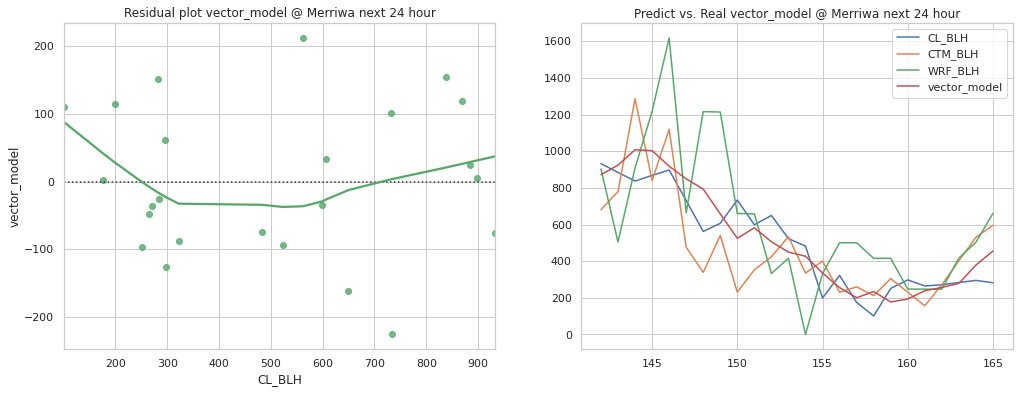

vector_model @ Merriwa next 24 hour
Index of agreement:0.95679
Root mean squared error:110.30330
Mean absoluate error:90.33966
Mean bias error:19.60309
DTW distance:1545.50
Mean Absolute scaled error:0.47793




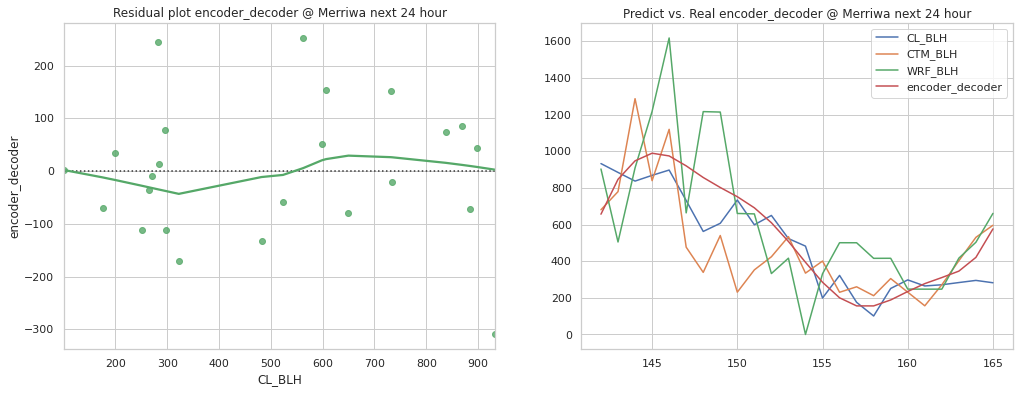

encoder_decoder @ Merriwa next 24 hour
Index of agreement:0.93724
Root mean squared error:134.05144
Mean absoluate error:104.12736
Mean bias error:43.66917
DTW distance:1850.33
Mean Absolute scaled error:0.55087




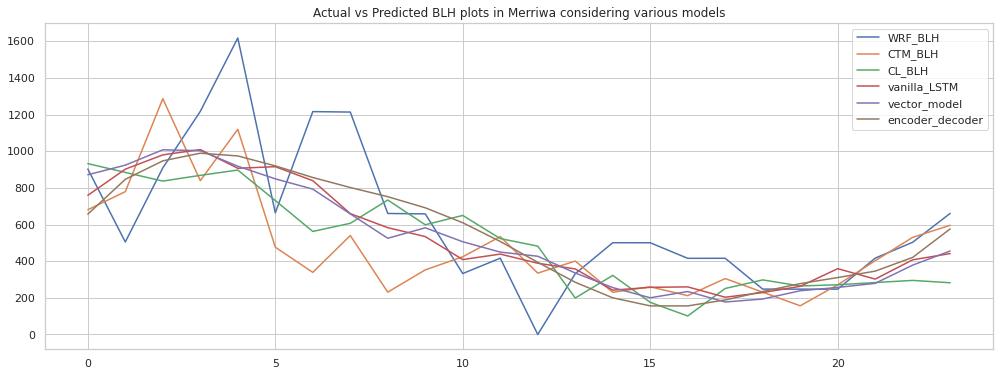

In [ ]:
overall_plot('Merriwa', feature_list)

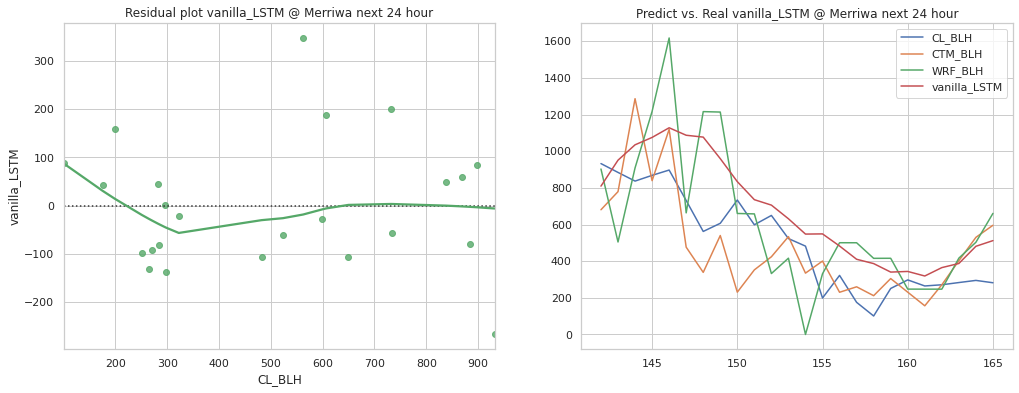

vanilla_LSTM @ Merriwa next 24 hour
Index of agreement:0.84609
Root mean squared error:216.53943
Mean absoluate error:181.38058
Mean bias error:171.12864
DTW distance:2804.22




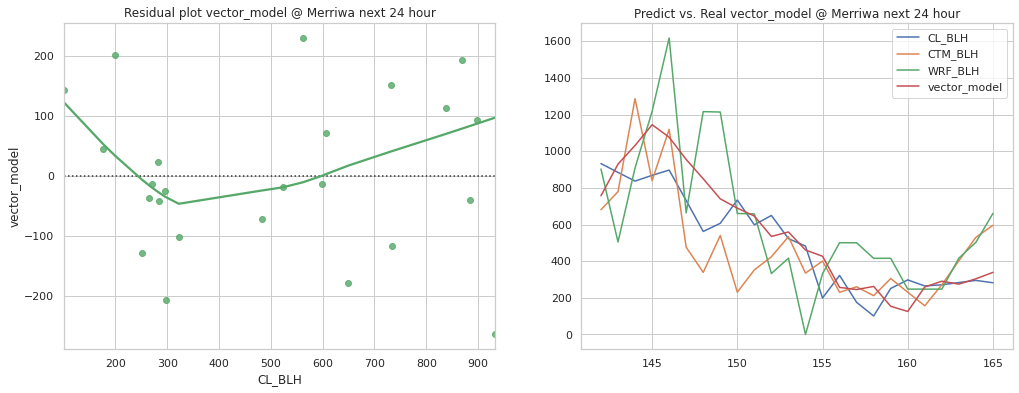

vector_model @ Merriwa next 24 hour
Index of agreement:0.93669
Root mean squared error:141.28549
Mean absoluate error:111.35795
Mean bias error:52.64622
DTW distance:1520.60




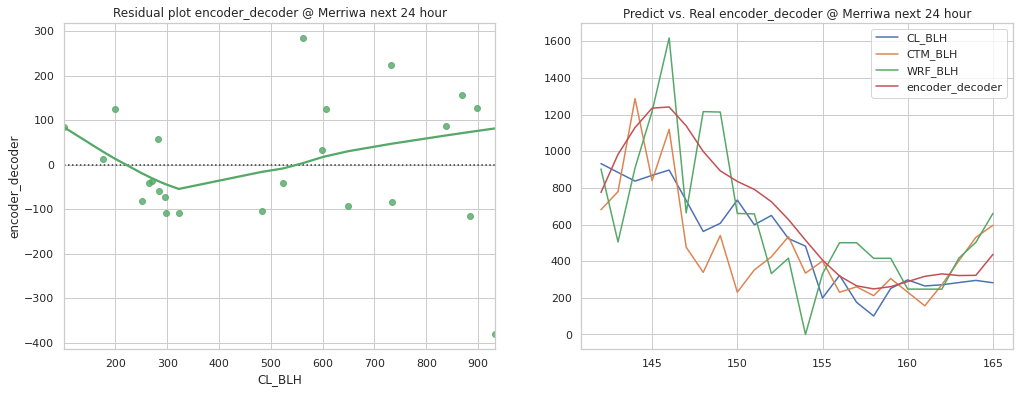

encoder_decoder @ Merriwa next 24 hour
Index of agreement:0.88809
Root mean squared error:202.36968
Mean absoluate error:154.04792
Mean bias error:139.86977
DTW distance:2459.30




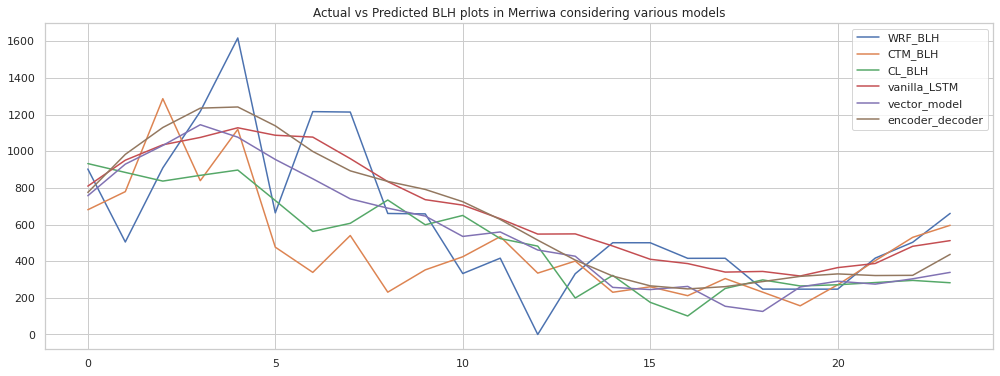

In [ ]:
overall_plot('Merriwa', ['CL_BLH'])